In [2]:
import pandas as pd

In [3]:
genes_set = pd.read_csv('gsets_1')
genes_set = genes_set.rename(columns={"YAL002W$YAL011W": "pairs"})
sl_labels = pd.read_csv('sl_1')
pairs_terms = genes_set.copy()
pairs_terms['sl'] = sl_labels
pairs_terms = pairs_terms.set_index('pairs')

In [4]:
from goatools.base import get_godag
godag = get_godag("go-basic.obo")

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms


In [5]:
from goatools.anno.gaf_reader import GafReader
ogaf = GafReader("goa_yeast.gaf")

HMS:0:00:02.479099  91,452 annotations READ: goa_yeast.gaf 


In [6]:
from collections import defaultdict
lookup_terms = defaultdict(set)
for assoc in ogaf.associations:
    for syn in assoc.DB_Synonym:
        lookup_terms[syn].add(assoc.GO_ID)

In [7]:
terms = defaultdict(set)
gene_pairs = pairs_terms.index.values
for idx, pair in enumerate(gene_pairs):
#     if idx % 1000 == 0:
#         print("working on {}/{}".format(idx, len(gene_pairs)))
    for gene in pair.split("$"):
        go_ids = lookup_terms.get(gene)
        if go_ids is None:
            print("Error", gene)
        else:
            for go_id in go_ids:
                term = godag.get(go_id)
                if term.namespace == 'biological_process':
                    terms[go_id].add(pair)

Error YIL168W
Error YIL170W


In [8]:
pairs_terms = pd.concat([pd.DataFrame(columns=terms.keys()), pairs_terms], sort=False)
pairs_terms = pairs_terms.fillna(0)

In [9]:
for term, pairs in terms.items():
    pairs_terms.loc[pairs, [term]] += 1

In [10]:
# # remove column without no information
# nunique = pairs_terms.apply(pd.Series.nunique)
# cols_to_drop = nunique[nunique == 1].index
# print("dropping {} columns".format(len(cols_to_drop)))
# pairs_terms.drop(cols_to_drop, axis=1)

In [11]:
# pairs_terms.to_pickle("pairs_terms.pkl")
pairs_terms = pd.read_pickle("pairs_terms.pkl")

In [12]:
X = pairs_terms.loc[:, pairs_terms.columns != 'sl']
Y = pairs_terms['sl']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [14]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs')

In [15]:
model.fit(X, Y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
standard_model = pd.read_csv('all.onto_genes.features.cv_all.rf.predictions')
standard_model[standard_model['0'] >= 0.5] = 1
standard_model[standard_model['0'] < 0.5] = 0
standard_model['pairs'] = pairs_terms.index.values
standard_model = standard_model.set_index('pairs')
standard_model = standard_model.rename(columns={"0": "sl"})

In [17]:
standard_model.to_pickle("standard_model.pkl")
# standard_model = pd.read_pickle("standard_model.pkl")

In [18]:
y_pred = model.predict(X)
from sklearn.metrics import accuracy_score
accuracy_score(Y, standard_model['sl'])

0.9552258814066759

In [19]:
accuracy_score(Y, y_pred)

0.9426471245363958

In [20]:
from sklearn.metrics import classification_report
target_names = ['non sl', 'sl']
print("theirs:")
print(classification_report(Y, standard_model, target_names=target_names))

theirs:
              precision    recall  f1-score   support

      non sl       0.96      0.99      0.98    124311
          sl       0.81      0.51      0.63      9963

   micro avg       0.96      0.96      0.96    134274
   macro avg       0.89      0.75      0.80    134274
weighted avg       0.95      0.96      0.95    134274



In [21]:
print("ours:")
print(classification_report(Y, y_pred, target_names=target_names))

ours:
              precision    recall  f1-score   support

      non sl       0.94      1.00      0.97    124311
          sl       0.88      0.26      0.41      9963

   micro avg       0.94      0.94      0.94    134274
   macro avg       0.91      0.63      0.69    134274
weighted avg       0.94      0.94      0.93    134274



Baseline: ROC AUC=0.500
Logistic: ROC AUC=0.872


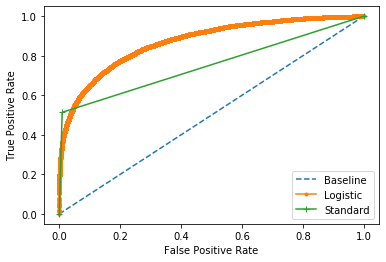

In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(Y))]
# predict probabilities
lr_probs = model.predict_proba(X)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y, ns_probs)
lr_auc = roc_auc_score(Y, lr_probs)
# summarize scores
print('Baseline: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y, lr_probs)
base_fpr, base_tpr, _ = roc_curve(Y, standard_model)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
pyplot.plot(base_fpr, base_tpr, marker='+', label='Standard')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()